In [1]:
import sksurv as sks
import sksurv.preprocessing
import sksurv.metrics
import sksurv.datasets
import sksurv.linear_model
import sksurv.ensemble

from pathlib import Path
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import sklearn as skl
import scipy.stats as sp

import pymc as pm
import pymc_bart as pmb
import pandas as pd

import importlib
import mlflow as ml
import simsurv_func as ssf
import subprocess
import lifelines
import pytensor.tensor as tt
import subprocess

In [2]:
importlib.reload(ssf)

<module 'simsurv_func' from '/home/twj8/pymc_bart/eval_5_cc/simsurv_func.py'>

In [14]:
lung = pd.read_csv("lung.csv")
lung["ph.karno"] = lung["ph.karno"].fillna(lung["pat.karno"])
lung["status"] = lung["status"] - 1
lung["time"] = np.ceil(lung["time"]/30)
train = lung[["time", "status", "sex", "age", "ph.karno"]]

In [15]:
train

,time,status,sex,age,ph.karno
0,11.0,1,1,74,90.0
1,16.0,1,1,68,90.0
2,34.0,0,1,56,90.0
3,7.0,1,1,57,90.0
4,30.0,1,1,60,100.0
...,...,...,...,...,...
223,7.0,0,1,77,80.0
224,7.0,0,1,39,90.0
225,4.0,0,2,75,60.0
226,6.0,0,1,66,90.0


In [65]:
TRAIN_CSV = "lung_train.csv"
RBART_CSV = "lung_result.csv"
train.to_csv(TRAIN_CSV)

# Set up pymc-bart

In [17]:
# get x,y in sklearn format
y_sk = ssf.get_y_sklearn(lung["status"], lung["time"])
x_sk = train.iloc[:,2:]

In [21]:
# get long format
# tranform data long-form
b_tr_t, b_tr_delta, b_tr_x = ssf.surv_pre_train2(x_sk, y_sk)
# b_te_t, b_te_x = surv_pre_test(x_sk, y_sk)
b_te_x = ssf.get_bart_test(x_sk, np.unique(b_tr_t))
off = sp.norm.ppf(np.mean(b_tr_delta))

In [26]:
with pm.Model() as bart:    
    x_data = pm.MutableData("x", b_tr_x)
    f = pmb.BART("f", 
            X=x_data, 
            Y=b_tr_delta,
            m=200, 
            split_rules = [pmb.ContinuousSplitRule(), 
                            pmb.OneHotSplitRule(),
                            pmb.ContinuousSplitRule(),
                            pmb.ContinuousSplitRule()])
    z = pm.Deterministic("z", f + off)
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    y_pred = pm.Bernoulli("y_pred", p=mu, observed=b_tr_delta, shape=x_data.shape[0])
    bdata = pm.sample(random_seed=2, draws=200, tune = 200, cores=4)

with bart:
    pm.set_data({"x":pd.DataFrame(b_te_x)}, coords= {"obs":np.arange(0,b_te_x.shape[0],1)})
    pp = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])



Only 200 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [f]


Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 72 seconds.
/home/twj8/.local/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [f, y_pred]


In [27]:
# transform to survival
bart_sv_fx = ssf.get_sv_fx(pp, x_sk)
# bart_svt
bart_sv_t = np.unique(b_tr_t)

# add a time 0 with prob 1 
bart_sv_t = np.concatenate([np.array([0]), bart_sv_t])
bart_sv_val = [np.concatenate([np.array([1]), sv]) for sv in bart_sv_fx]


In [62]:
# get raw probs
n_t = np.unique(b_tr_t).shape[0]
n = x_sk.shape[0]
bart_prob_val = pp.posterior_predictive["mu"].mean(("chain","draw")).values.reshape(n, n_t)

# Run RBART

In [70]:
p1 = subprocess.Popen([
        "Rscript",
        "lung_run.r",
        TRAIN_CSV,
        RBART_CSV
        ])
p1.wait()

Loading required package: nlme
Loading required package: nnet
Loading required package: survival


*****Calling gbart: type=2
*****Data:
data:n,p,np: 2378, 4, 7068
y1,yn: 0.000000, 0.000000
x1,x[n*p]: 1.000000, 80.000000
xp1,xp[np*p]: 1.000000, 80.000000
*****Number of Trees: 50
*****Number of Cut Points: 30 ... 5
*****burn,nd,thin: 250,1250,10
*****Prior:beta,alpha,tau,nu,lambda,offset: 2,0.95,0.212132,3,1,-1.48038
*****Dirichlet:sparse,theta,omega,a,b,rho,augment: 0,0,1,0.5,1,4,0
*****printevery: 100

MCMC
done 0 (out of 1500)
done 100 (out of 1500)
done 200 (out of 1500)
done 300 (out of 1500)
done 400 (out of 1500)
done 500 (out of 1500)
done 600 (out of 1500)
done 700 (out of 1500)
done 800 (out of 1500)
done 900 (out of 1500)
done 1000 (out of 1500)
done 1100 (out of 1500)
done 1200 (out of 1500)
done 1300 (out of 1500)
done 1400 (out of 1500)
time: 6s
trcnt,tecnt: 125,125


0

In [71]:
rbart = pd.read_csv(RBART_CSV)
rbart

,Unnamed: 0,t,sex,age,ph.karno,prob,surv
0,1,1,1,74,90,0.054480,0.944566
1,2,2,1,74,90,0.051613,0.894987
2,3,3,1,74,90,0.058638,0.845446
3,4,4,1,74,90,0.057810,0.796389
4,5,5,1,74,90,0.072639,0.741733
...,...,...,...,...,...,...,...
7063,7064,28,2,58,80,0.143306,0.104597
7064,7065,30,2,58,80,0.145415,0.092566
7065,7066,33,2,58,80,0.140185,0.082846
7066,7067,34,2,58,80,0.140185,0.074511


In [72]:
# get rbart components
tshape = np.unique(train["time"]).shape[0]
N = train.shape[0]
rb_surv_val = rbart["surv"].to_numpy().reshape((N,tshape))
rb_prob_val = rbart["prob"].to_numpy().reshape((N,tshape))
rb_mat = rbart[["sex","age","ph.karno"]][rbart["t"] == 1].to_numpy()
rb_time = train["time"].to_numpy()
rb_delta = train["status"].to_numpy()

# Metrics

In [92]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

## C-index

In [105]:
# get the quantiles to evaluate on 0.25, 0.5,0.75
idx_quant = [np.array(np.round(x),dtype="int") for x in (tshape*.25, tshape*.5, tshape*.75)]

# empy array
rb_cindx = np.zeros(shape=(len(idx_quant)))
pb_cindx = np.zeros(shape=(len(idx_quant)))

# get c-index
for idx, i in enumerate(idx_quant):
    rb_cindx[idx] = concordance_index_censored(
                event_indicator=y_sk["Status"],
                event_time=y_sk["Survival_in_days"],
                estimate=rb_prob_val[:,i]
            )[0]
    pb_cindx[idx] = concordance_index_censored(
                event_indicator=y_sk["Status"],
                event_time=y_sk["Survival_in_days"],
                estimate=bart_prob_val[:,i]
            )[0]

In [121]:
print(f"CINDEX at .25, .5, .75 quantile times using probability values")
print(f"RBART CINDEX: {rb_cindx}")
print(f"PYMC-BART CINDEX: {pb_cindx}")

CINDEX at .25, .5, .75 quantile times using probability values
RBART CINDEX: [0.67574862 0.66485028 0.65868812]
PYMC-BART CINDEX: [0.67798941 0.66826238 0.66459564]


## TIME-AUC


In [150]:
# get the quantiles to evaluate on 0.25, 0.5,0.75
idx_quant = [np.array(np.round(x),dtype="int") for x in (tshape*.1, tshape*.25, tshape*.5, tshape*.75, tshape*.9)]
rb_uniq_t = np.unique(rb_time)

r_cda = cumulative_dynamic_auc(survival_train=y_sk, survival_test=y_sk, estimate=rb_prob_val[:, idx_quant], times=rb_uniq_t[idx_quant])
p_cda = cumulative_dynamic_auc(survival_train=y_sk, survival_test=y_sk, estimate=bart_prob_val[:,idx_quant], times=rb_uniq_t[idx_quant])

In [153]:
print(f"PYMC Cumul Dynamic AUC {p_cda[0]} \n AVE {p_cda[1]}")
print(f"RBART Cumul Dynamic AUC {r_cda[0]} \n AVE {r_cda[1]}")

PYMC Cumul Dynamic AUC [0.73119422 0.71307456 0.73028577 0.76624123 0.68303805] 
 AVE 0.7294253776513039
RBART Cumul Dynamic AUC [0.72235953 0.71081333 0.70402549 0.76024754 0.81044728] 
 AVE 0.7240981322967871


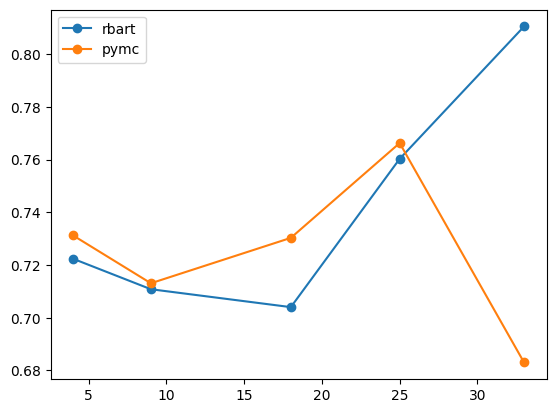

In [156]:
plt.plot(rb_uniq_t[idx_quant], r_cda[0], marker="o", label="rbart")
plt.plot(rb_uniq_t[idx_quant], p_cda[0], marker="o", label="pymc")
plt.legend()

## BRIER SCORE

In [166]:
p_ibs = integrated_brier_score(y_sk, y_sk, bart_sv_fx[:, 1:-1], rb_uniq_t[1:-1])
r_ibs = integrated_brier_score(y_sk, y_sk, rb_surv_val[:, 1:-1], rb_uniq_t[1:-1])

print(f"PYMC BRIER SCORE: {p_ibs}")
print(f"RBART BRIER SCORE: {r_ibs}")

PYMC BRIER SCORE: 0.13935183266688536
RBART BRIER SCORE: 0.13987720523490046


In [145]:
# bart_sv_t[idx_quant]
# rb_prob_val[0].shape
# rb_time[idx_quant]
# np.unique(rb_time)[idx_quant]
rb_uniq_t[idx_quant]
rb_prob_val[:,idx_quant]

array([[0.05781015, 0.08679467, 0.14733437, 0.17916646, 0.1764088 ],
       [0.04696284, 0.07172748, 0.13131531, 0.16254169, 0.16230922],
       [0.04722573, 0.06880152, 0.10728298, 0.13391318, 0.13339585],
       ...,
       [0.07176309, 0.08895941, 0.14431782, 0.19627642, 0.18630086],
       [0.05341542, 0.07938317, 0.12731213, 0.15678294, 0.156683  ],
       [0.03544152, 0.05472997, 0.09266077, 0.14531234, 0.14018476]])

# Plot Posterior Predictive on sex (NOT A FPD)

In [190]:
# add the 0 time sv val
rb_surv_adj = np.hstack([np.repeat(1, rb_surv_val.shape[0]).reshape(rb_surv_val.shape[0],1), rb_surv_val])
rb_t_adj = np.hstack([0, rb_uniq_t])

rb_ml = rb_surv_adj[rb_mat[:,0] == 1,:]
rb_fl = rb_surv_adj[rb_mat[:,0] == 2,:]


In [219]:
p_ml = np.array(bart_sv_val)[rb_mat[:,0]==1,:]
p_fl = np.array(bart_sv_val)[rb_mat[:,0]==2,:]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


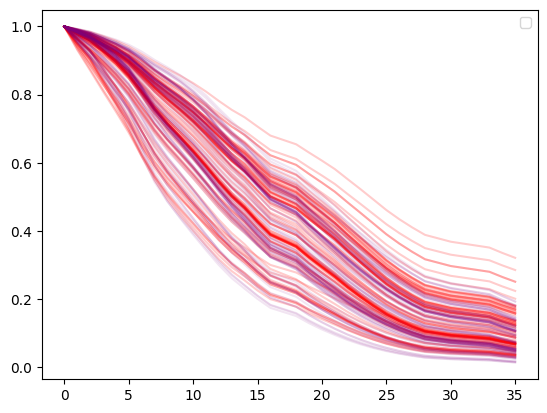

In [229]:
plt.plot(rb_t_adj.T, rb_fl.T, color="red", alpha=0.2)
plt.plot(bart_sv_t.T, p_fl.T, color = "purple", alpha=0.1)
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


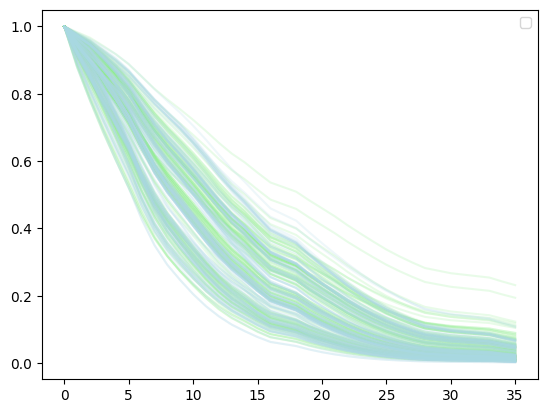

In [230]:
plt.plot(rb_t_adj.T, rb_ml.T, color="lightgreen", alpha=0.2)
plt.plot(bart_sv_t.T, p_ml.T, color = "lightblue", alpha=0.2)
plt.legend()

## pat level difference

In [274]:
diff_mean = np.zeros_like(rb_t_adj)
diff_95 = np.zeros_like(rb_t_adj)
diff_05 = np.zeros_like(rb_t_adj)
diff_25 = np.zeros_like(rb_t_adj)
diff_50 = np.zeros_like(rb_t_adj)
diff_75 = np.zeros_like(rb_t_adj)
for idx, i in enumerate(rb_t_adj):
    diff = rb_surv_adj[:,idx] - np.array(bart_sv_val)[:,idx]
    diff_mean[idx] = diff.mean()
    # print(diff)
    
    diff_pc = np.quantile(diff, [0.05, .25, .5, .75, 0.95])
    # print(diff_pc)
    
    diff_05[idx] = diff_pc[0]
    diff_25[idx] = diff_pc[1]
    diff_50[idx] = diff_pc[2]
    diff_75[idx] = diff_pc[3]
    diff_95[idx] = diff_pc[4]

    # print(diff_pc)
    # print(i)


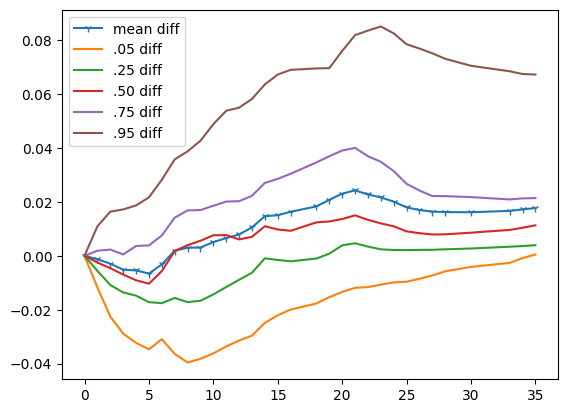

In [278]:
plt.plot(rb_t_adj, diff_mean, label = "mean diff", marker="1")
plt.plot(rb_t_adj, diff_05, label = ".05 diff")
plt.plot(rb_t_adj, diff_25, label = ".25 diff")
plt.plot(rb_t_adj, diff_50, label = ".50 diff")
plt.plot(rb_t_adj, diff_75, label = ".75 diff")
plt.plot(rb_t_adj, diff_95, label = ".95 diff")
plt.legend()

Mean abs difference hangs around 0.01
The increasing trend with time indicates the PYMC bart approaches 0% survival slightly more quickly than the RBART. However as the mean and 50% interval indicates that the difference is fairly insiginificant across most of the matched patient values.